In [1]:
import numpy as np
import xarray as xr
import extremespaper as ex
import viz
import mplRC
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cftime
import datetime as dt
import os
import glob
import matplotlib.cm as mcm

mplRC.paperRC2()

/home/ords/crd/ccrn/reo000/mamba_files/envs/mpy39dc/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


#### start with temperature events relative to historical ~1995 level (midpoint of historical slice), no adaptation
A) historical 95th percentile extreme days, non-seasonal definition, raw basis (relative to 1975-2014)

C) historical 95th percentile extreme days, seasonal definition, raw basis (relative to 1975-2014)

E) 40-year window MMMm running mean (~95th percentile) threshold, non-seasonal (relative to previous 40 years)

In [2]:
qq=.95
freq='daily'
chdef0={'time':-1,'lat':90,'lon':90}
scenNameref='ESM4_historical_D1'
yrspanref=ex.dictScenDates[scenNameref]
dirstr={1:'max',-1:'min'}

vstrs={'tos':'SST',
       'hplusos':'Surface H$^+$',
       'omega_arag_0':'Surface $\Omega _{arag}$',
       'o2_mean_100_600':'100-600m Mean O$_2$',
       'spco2':'Surface pCO$_2$'}

cmin=1/(365*40)*100

In [3]:
ff={}
sf={}
for ivar in ['tos','hplusos','omega_arag_0','spco2']:
    exdir=ex.exdirs[ivar]
    quant=qq if exdir==1 else np.round(1-qq,2)
    qstring=f"p{quant*100}"
    print(ivar,exdir)
    sf[ivar]=xr.open_dataset(ex.fNameStatsFile('ESM4_historical_D1',
                                               ex.dictScenDates['ESM4_historical_D1'],'daily',ivar))
    for iscen in ['ESM4_historical_D1','ESM4_ssp126_D1','ESM4_ssp370_D1']:
        yrspan=ex.dictScenDates[iscen]
        fp0=ex.exstats_path(ivar,iscen,yrspan,scenNameref,yrspanref,freq,exdir,quant,calcDurAmp=False,grid='1x1')
        if os.path.exists(fp0):
            ff[(ivar,iscen)]=xr.open_dataset(fp0)
            print(fp0)
        else:
            raise Exception(f'file missing: {fp0}')

tos 1
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_GFDL-ESM4.1.ESM4_historical_D1.1975_2014.refESM4_historical_D1.1975_2014.daily.tos.max.p95.0.1x1.nc
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_GFDL-ESM4.1.ESM4_ssp126_D1.2061_2100.refESM4_historical_D1.1975_2014.daily.tos.max.p95.0.1x1.nc
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_GFDL-ESM4.1.ESM4_ssp370_D1.2061_2100.refESM4_historical_D1.1975_2014.daily.tos.max.p95.0.1x1.nc
hplusos 1
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_GFDL-ESM4.1.ESM4_historical_D1.1975_2014.refESM4_historical_D1.1975_2014.daily.hplusos.max.p95.0.1x1.nc
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_GFDL-ESM4.1.ESM4_ssp126_D1.2061_2100.refESM4_historical_D1.1975_2014.daily.hplusos.max.p95.0.1x1.nc
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/cal

In [4]:
hist='ESM4_historical_D1'
s126='ESM4_ssp126_D1'
s370='ESM4_ssp370_D1'

In [5]:
proj=ccrs.Robinson(central_longitude=-170)
lons=viz.lonvec1x1
lats=viz.latvec1x1
# cmb=cmocean.cm.balance
# cmb.set_bad('w',alpha=0)

# colors1 = cmocean.cm.thermal(np.linspace(.1, 1, 100))
# colors2 = np.zeros((1,4))
# colors2[:,-1]=1.
# cm1b = mcolors.LinearSegmentedColormap.from_list('kzerotherm',  np.vstack((colors2, colors1)))
# cm1b.set_bad('w',alpha=0)
# cm1=mcolors.LinearSegmentedColormap.from_list('kzerotherm2',  colors1)
# cm1.set_bad('w',alpha=0)
# cm1.set_under('k')

In [6]:
def plot_sns_small(ivar):
    fig,ax=plt.subplots(2,4,figsize=(8,3),gridspec_kw={'hspace':.1,'wspace':.1,
                                                       'width_ratios':[1,1,1,.1]},
                                          subplot_kw={'projection':proj,'facecolor':'darkgray'})
    for iax in ax[:,3]: iax.remove()
    ax[0,3]=fig.add_axes([.9,.65,.02,.2])
    ax[1,3]=fig.add_axes([.9,.38,.02,.2])
    #ax[2,3]=fig.add_axes([.9,.12,.02,.2])

    ax[0,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,hist]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    ax[0,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    m=ax[0,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    fig.colorbar(m,cax=ax[0,3])
    ax[1,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,hist]['is_exD_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    ax[1,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exD_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    m=ax[1,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exD_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    fig.colorbar(m,cax=ax[1,3])
    #fig.suptitle(f'Extreme Event Days, No Adaptation, raw 1975-2014 95/5 reference,'
    #             f'{vstrs[ivar]}',y=1.02)

    

    for iax in (ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2]):
        iax.set_xticks([])
        iax.set_yticks([])
    ax[0,0].set_title('Historical')
    ax[0,1].set_title('SSP1-2.6')
    ax[0,2].set_title('SSP3-7.0')
    ax[0,0].set_ylabel('SC Threshold')
    ax[1,0].set_ylabel('SV Threshold')
    return fig,ax


In [7]:
def plot_sns(ivar):
    fig,ax=plt.subplots(3,4,figsize=(8,4),gridspec_kw={'hspace':.1,'wspace':.1,
                                                       'width_ratios':[1,1,1,.1]},
                                          subplot_kw={'projection':proj,'facecolor':'darkgray'})
    for iax in ax[:,3]: iax.remove()
    ax[0,3]=fig.add_axes([.9,.39,.012,.46])
    #ax[1,3]=fig.add_axes([.9,.38,.02,.2])
    ax[2,3]=fig.add_axes([.9,.11,.012,.2])

    ax[0,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,hist]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    ax[0,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    m=ax[0,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    #fig.colorbar(m,cax=ax[0,3])
    fig.colorbar(mcm.ScalarMappable(norm=mcolors.Normalize(vmin=0,vmax=100), cmap=viz.cm1b),cax=ax[0,3]); ax[0,3].set_title('%')
    ax[1,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,hist]['is_exD_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    ax[1,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exD_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    m=ax[1,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exD_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    #fig.colorbar(m,cax=ax[1,3])
    fig.suptitle(f'Extreme Event Days, 1975-2014 Reference Period, {vstrs[ivar]}',y=1.0)

    ax[2,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,hist]['is_exD_sum']-ff[ivar,hist]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=-100,vmax=100,cmap=viz.cmb)
    ax[2,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exD_sum']-ff[ivar,s126]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=-100,vmax=100,cmap=viz.cmb)
    m=ax[2,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exD_sum']-ff[ivar,s370]['is_exA_sum'])/(365*40)*100,
                         transform=ccrs.PlateCarree(),vmin=-100,vmax=100,cmap=viz.cmb)
    fig.colorbar(m,cax=ax[2,3]); ax[2,3].set_title('%')

    for iax in (ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2],ax[2,0],ax[2,1],ax[2,2]):
        iax.set_xticks([])
        iax.set_yticks([])
    ax[0,0].set_title('Historical')
    ax[0,1].set_title('SSP1-2.6')
    ax[0,2].set_title('SSP3-7.0')
    ax[0,0].set_ylabel('SC Threshold')
    ax[1,0].set_ylabel('SV Threshold')
    ax[2,0].set_ylabel('Difference\nSV$-$SC')
    return fig,ax


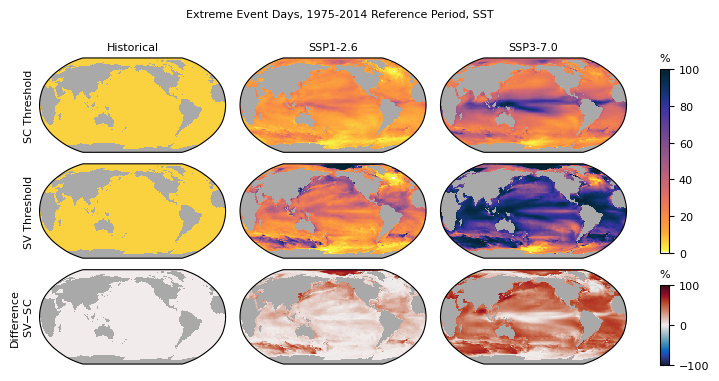

In [8]:
ivar='tos'
fig,ax=plot_sns(ivar)
fig.savefig(f'global_extremes_seas_{ivar}_diff_newcm.png', dpi=300,bbox_inches='tight')

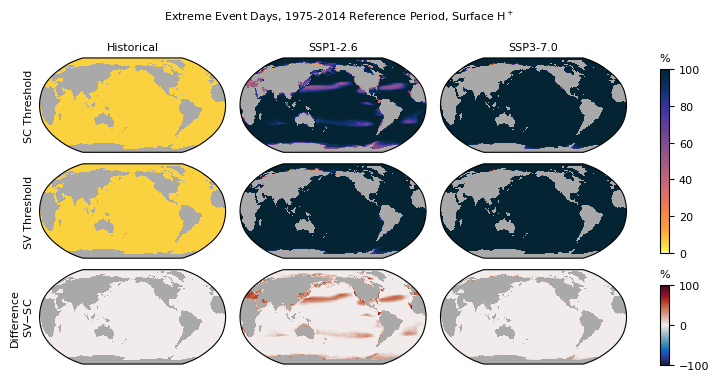

In [9]:
ivar='hplusos'
fig,ax=plot_sns(ivar)
fig.savefig(f'global_extremes_seas_{ivar}_diff_newcm.png',dpi=300,bbox_inches='tight')

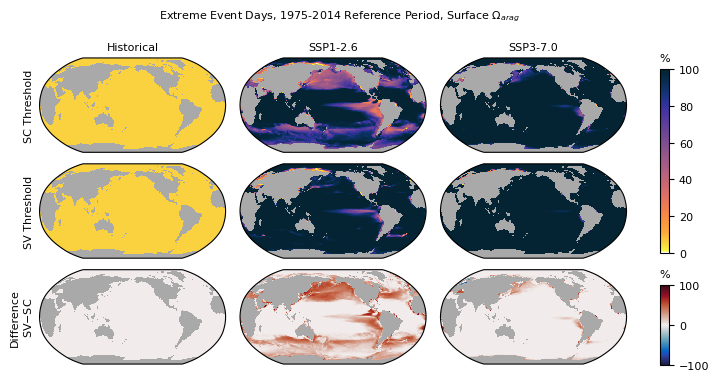

In [10]:
ivar='omega_arag_0'
fig,ax=plot_sns(ivar)
fig.savefig(f'global_extremes_seas_{ivar}_diff_newcm.png',dpi=300,bbox_inches='tight')

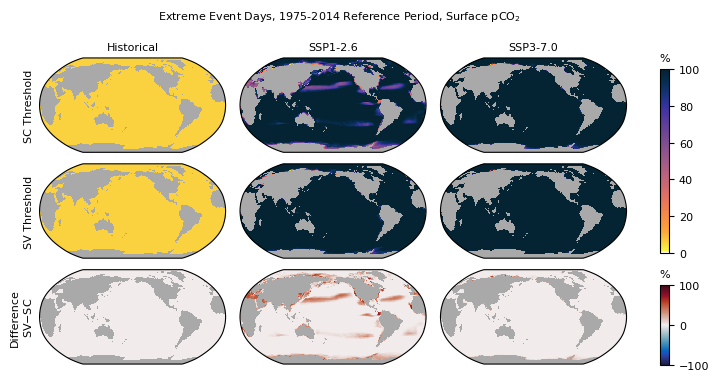

In [11]:
ivar='spco2'
fig,ax=plot_sns(ivar)
fig.savefig(f'global_extremes_seas_{ivar}_diff_newcm.png',dpi=300,bbox_inches='tight')

In [12]:
def plot_snsAdapt(ivar):
    fig,ax=plt.subplots(3,8,figsize=(12,3.6),gridspec_kw={'hspace':.1,'wspace':.05,
                                                       'width_ratios':[1,1,1,.09,.09,1,1,.1],},
                                          subplot_kw={'projection':proj,'facecolor':'darkgray'})
    for iax in ax[:,3]: iax.remove()
    for iax in ax[:,4]: iax.remove()
    ax[0,3]=fig.add_axes([.56,.39,.006,.46])
    #ax[1,3]=fig.add_axes([.55,.39,.006,.2])
    #ax[2,3]=fig.add_axes([.55,.13,.006,.2])
    for iax in ax[:,7]: iax.remove()
    #ax[0,7]=fig.add_axes([.9,.66,.006,.2])
    ax[1,7]=fig.add_axes([.885,.39,.006,.46])
    ax[2,7]=fig.add_axes([.9,.13,.006,.2])
    for iax in ax[2,5:]: iax.remove()

    ax[0,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,hist]['is_exE100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    ax[0,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exE100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    m=ax[0,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exE100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    #fig.colorbar(m,cax=ax[0,3])
    fig.colorbar(mcm.ScalarMappable(norm=mcolors.Normalize(vmin=0,vmax=100), cmap=viz.cm1b),cax=ax[0,3]); ax[0,3].set_title('%')
    ax[0,5].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exE100_sum']-ff[ivar,hist]['is_exE100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=-100,vmax=100,cmap=viz.cmb)
    m=ax[0,6].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exE100_sum']-ff[ivar,hist]['is_exE100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=-100,vmax=100,cmap=viz.cmb)
    #fig.colorbar(m,cax=ax[0,7])
    ax[1,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,hist]['is_exG100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    ax[1,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exG100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    m=ax[1,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exG100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    #fig.colorbar(m,cax=ax[1,3])
    ax[1,5].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exG100_sum']-ff[ivar,hist]['is_exG100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=-100,vmax=100,cmap=viz.cmb)
    m=ax[1,6].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exG100_sum']-ff[ivar,hist]['is_exG100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=-100,vmax=100,cmap=viz.cmb)
    fig.colorbar(m,cax=ax[1,7]);ax[1,7].set_title('%')
    fig.suptitle(f'Extreme Event Days, 100-year Adaptation, {vstrs[ivar]}',y=.97)

    ax[2,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,hist]['is_exG100_sum']-ff[ivar,hist]['is_exE100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=-100,vmax=100,cmap=viz.cmb)
    ax[2,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exG100_sum']-ff[ivar,s126]['is_exE100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=-100,vmax=100,cmap=viz.cmb)
    m=ax[2,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exG100_sum']-ff[ivar,s370]['is_exE100_sum'])/(365*40)*100,
                         transform=ccrs.PlateCarree(),vmin=-100,vmax=100,cmap=viz.cmb)
    #fig.colorbar(m,cax=ax[2,3])

    for iax in (ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2],ax[2,0],ax[2,1],ax[2,2]):
        iax.set_xticks([])
        iax.set_yticks([])
    ax[0,0].set_title('Historical')
    ax[0,1].set_title('SSP1-2.6')
    ax[0,2].set_title('SSP3-7.0')
    ax[0,5].set_title('SSP1-2.6 - Historical')
    ax[0,6].set_title('SSP3-7.0 - Historical')
    ax[0,0].set_ylabel('SC Threshold')
    ax[1,0].set_ylabel('SV Threshold')
    ax[2,0].set_ylabel('Difference\nSV$-$SC',labelpad=-3)
    return fig,ax


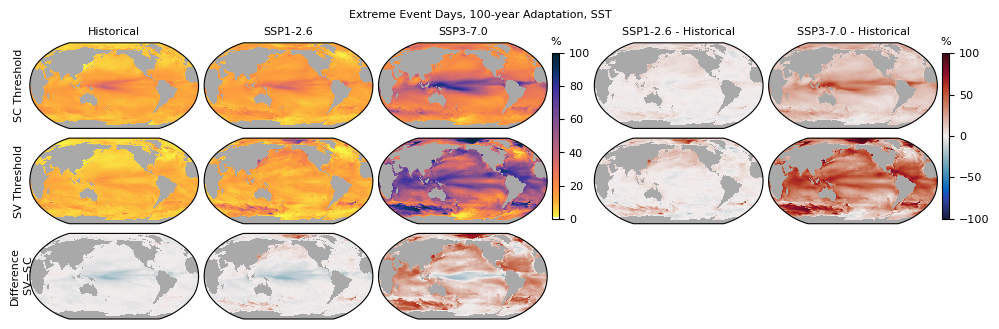

In [13]:
ivar='tos'
fig,ax=plot_snsAdapt(ivar)
fig.savefig(f'global_extremes_seasAdapt_{ivar}_diff_newcm.png',dpi=300,bbox_inches='tight')

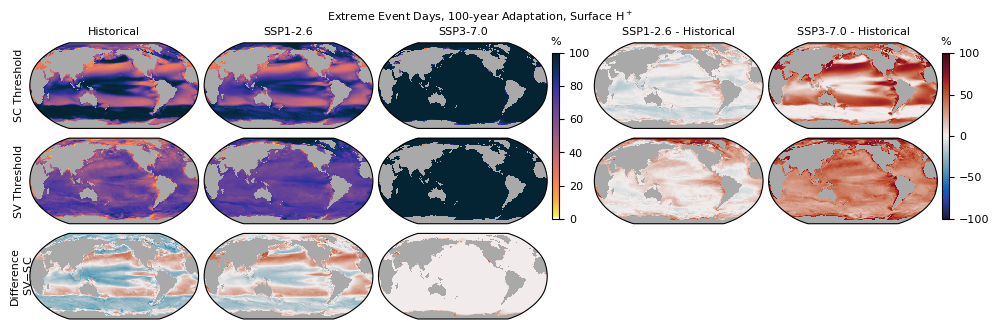

In [14]:
ivar='hplusos'
fig,ax=plot_snsAdapt(ivar)
fig.savefig(f'global_extremes_seasAdapt_{ivar}_diff_newcm.png',dpi=300,bbox_inches='tight')

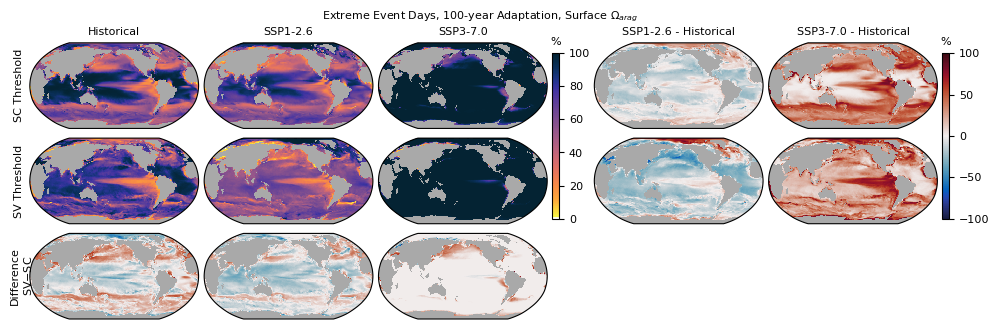

In [15]:
ivar='omega_arag_0'
fig,ax=plot_snsAdapt(ivar)
fig.savefig(f'global_extremes_seasAdapt_{ivar}_diff_newcm.png',dpi=300,bbox_inches='tight')

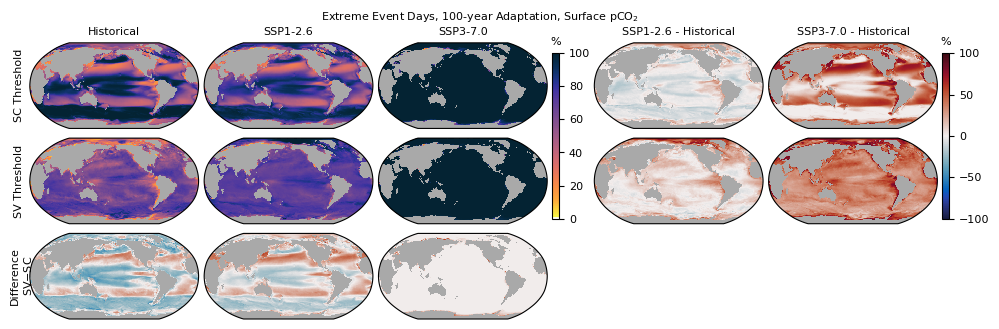

In [16]:
ivar='spco2'
fig,ax=plot_snsAdapt(ivar)
fig.savefig(f'global_extremes_seasAdapt_{ivar}_diff_newcm.png',dpi=300,bbox_inches='tight')

In [17]:
# adaptive - non-adaptive
cmm=30
def plot_snsAdapt_seasdiff(ivar,cb=True):
    cmin=1/(40*365)
    fig,ax=plt.subplots(2,4,figsize=(8,2.7),gridspec_kw={'hspace':.05,'wspace':.05,
                                                       'width_ratios':[1,1,1,.1]},
                                          subplot_kw={'projection':proj,'facecolor':'darkgray'})
    for iax in ax[:,3]: iax.remove()
    if cb: ax[0,3]=fig.add_axes([.88,.16,.02,.65])
    #ax[1,3]=fig.add_axes([.87,.16,.02,.3])

    ax[0,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,hist]['is_exE100_sum']-ff[ivar,hist]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=-1*cmm,vmax=cmm,cmap=viz.cmb)
    ax[0,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exE100_sum']-ff[ivar,s126]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=-1*cmm,vmax=cmm,cmap=viz.cmb)
    m=ax[0,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exE100_sum']-ff[ivar,s370]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=-1*cmm,vmax=cmm,cmap=viz.cmb)
    if cb: 
        fig.colorbar(mcm.ScalarMappable(norm=mcolors.Normalize(vmin=-1*cmm,vmax=cmm), cmap=viz.cmb),cax=ax[0,3]); 
        ax[0,3].set_title('%')
    ax[1,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,hist]['is_exG100_sum']-ff[ivar,hist]['is_exD_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=-1*cmm,vmax=cmm,cmap=viz.cmb)
    ax[1,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exG100_sum']-ff[ivar,s126]['is_exD_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=-1*cmm,vmax=cmm,cmap=viz.cmb)
    m=ax[1,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exG100_sum']-ff[ivar,s370]['is_exD_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=-1*cmm,vmax=cmm,cmap=viz.cmb)
    #fig.colorbar(m,cax=ax[1,3])
    fig.suptitle(f'Extreme Event Days, Adapting Reference - Fixed Reference,'
                 f'{vstrs[ivar]}',y=1.0)

    

    for iax in (ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2]):
        iax.set_xticks([])
        iax.set_yticks([])
    ax[0,0].set_title('historical\n1975-2014')
    ax[0,1].set_title('ssp1-2.6\n2061-2100')
    ax[0,2].set_title('ssp3-7.0,\n2061-2100')
    ax[0,0].set_ylabel('Non-seasonal\nThreshold')
    ax[1,0].set_ylabel('Seasonal\nThreshold')
    return fig,ax

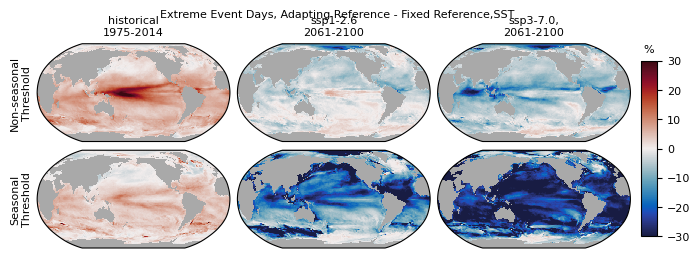

In [18]:
ivar='tos'
fig,ax=plot_snsAdapt_seasdiff(ivar)
#fig.savefig(f'global_extremes_seasAdapt_{ivar}_seasdiff.png',dpi=300,bbox_inches='tight')

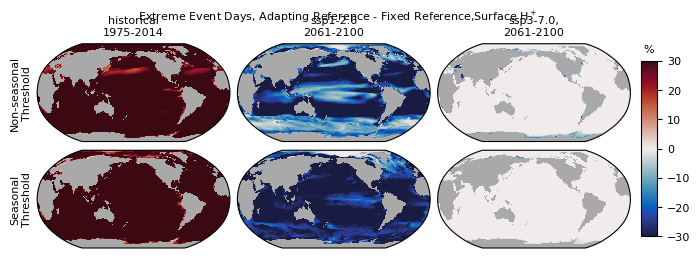

In [19]:
ivar='hplusos'
fig,ax=plot_snsAdapt_seasdiff(ivar)
#fig.savefig(f'global_extremes_seasAdapt_{ivar}_seasdiff.png',dpi=300,bbox_inches='tight')

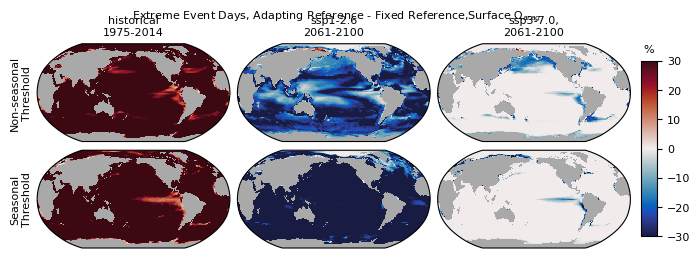

In [20]:
ivar='omega_arag_0'
fig,ax=plot_snsAdapt_seasdiff(ivar)
#fig.savefig(f'global_extremes_seasAdapt_{ivar}_seasdiff.png',dpi=300,bbox_inches='tight')

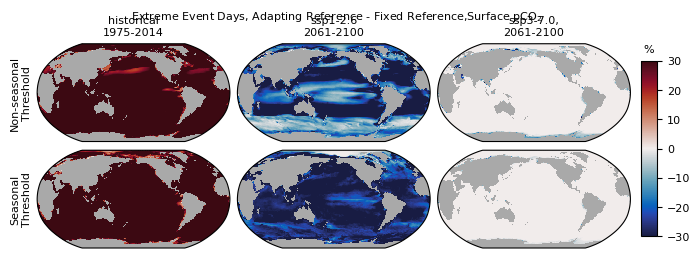

In [21]:
ivar='spco2'
fig,ax=plot_snsAdapt_seasdiff(ivar)
#fig.savefig(f'global_extremes_seasAdapt_{ivar}_seasdiff.png',dpi=300,bbox_inches='tight')